#### Basic LSTM's to classify genres
In this notebook, we configure and train a basic Long Short-Term Memory Networks (LSTM's). 

In [166]:
# import libraries
import pandas as pd 
import numpy as np
import math

import torch
from torch import nn, optim
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import pickle

# metrics
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [167]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

First, we get the data. 

In [168]:
df = pd.read_csv('data/5000_booksummaries.zip', compression='zip')
df.head(5)

,Text
0,Generate a book summary with genres Science Fi...
1,Generate a book summary with genres Fantasy:\n...
2,Generate a book summary with genres Crime Fict...
3,"Generate a book summary with genres Fiction, N..."
4,"Generate a book summary with genres War novel,..."


#### Preprocessing:
We use an 80/10/10 split and then tokenize. We also build the vocabulary and convert words to their vocab indexes.

In [169]:
# split into train (80%), val (10%), test (10%)
train_dataset, test_val_dataset = train_test_split(df, test_size=.2, random_state=8)
val_dataset, test_dataset = train_test_split(test_val_dataset, test_size=.5, random_state=8)

print(len(train_dataset), len(val_dataset), len(test_dataset))

4000 500 500


In [170]:
tokenizer = get_tokenizer("basic_english")
df['tokenized_text'] = df['Text'].apply(tokenizer)
df.head(5)

,Text,tokenized_text
0,Generate a book summary with genres Science Fi...,"[generate, a, book, summary, with, genres, sci..."
1,Generate a book summary with genres Fantasy:\n...,"[generate, a, book, summary, with, genres, fan..."
2,Generate a book summary with genres Crime Fict...,"[generate, a, book, summary, with, genres, cri..."
3,"Generate a book summary with genres Fiction, N...","[generate, a, book, summary, with, genres, fic..."
4,"Generate a book summary with genres War novel,...","[generate, a, book, summary, with, genres, war..."


In [171]:
def load_words(ds):
    words = []
    for _, row in ds.iterrows():
        words.extend(tokenizer(row['Text']))
    return words

In [183]:
train_words = load_words(train_dataset)
val_words = load_words(val_dataset)
test_words = load_words(test_dataset)

print(train_words[:5])

['generate', 'a', 'book', 'summary', 'with']


In [266]:
vocab = build_vocab_from_iterator(df['tokenized_text'])
vocab.insert_token('<unk>', 0)
vocab.set_default_index(vocab['<unk>'])     
print(len(vocab))                         
print(vocab.get_itos()[:10])     

76590
['<unk>', 'the', ',', '.', 'to', 'and', 'a', 'of', 'in', 'is']


In [283]:
def get_data(dataset, vocab, batch_size):
    dataset.append('<eos>')                                                      
    tokens = [vocab[token] for token in dataset]     
    data = torch.LongTensor(tokens)                                 
    num_batches = data.shape[0] // batch_size 
    data = data[:num_batches * batch_size]                       
    data = data.view(batch_size, num_batches)          
    return data

In [268]:
batch_size = 128
train_data = get_data(train_words, vocab, batch_size)
val_data = get_data(val_words, vocab, batch_size)
test_data = get_data(test_words, vocab, batch_size)

#### LSTM Class
We initialize our simple LSTM layer with dropout rate of 0.5. We also define the forward pass and output the next hidden layer and cell state.

In [176]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):    
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                    dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        

    def forward(self, src, hidden):
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding, hidden)          
        output = self.dropout(output) 
        prediction = self.fc(output)
        return prediction, hidden
    
    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell
    
    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

In [177]:
vocab_size = len(vocab)
embedding_dim = 128 
hidden_dim = 512             
num_layers = 3
dropout_rate = 0.5                             
lr = 1e-3

In [285]:
# we use Adam optimizer and CrossEntropyLoss
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

#### Training and Evaluation functions

In [179]:
def get_batch(data, seq_len, num_batches, idx):
    src = data[:, idx:idx+seq_len]                   
    target = data[:, idx+1:idx+seq_len+1]             
    return src, target

In [180]:
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):
    
    epoch_loss = 0
    model.train()
    # drop all batches that are not a multiple of seq_len
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)
    
    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):  # The last batch can't be a src
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)

        src, target = get_batch(data, seq_len, num_batches, idx)
        src, target = src.to(device), target.to(device)
        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)               

        prediction = prediction.reshape(batch_size * seq_len, -1)   
        target = target.reshape(-1)
        loss = criterion(prediction, target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [269]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, num_batches, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

#### Training and Validating Cycle

In [ ]:
n_epochs = 25
seq_len = 50
clip = 0.25
saved = False

training_stats = []
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
best_val_loss = float('inf')

for epoch in range(n_epochs):
  print("")
  print('======== Epoch {:} out of {:} ========'.format(epoch + 1, n_epochs))
  print('Training...')
  train_loss = train(model, train_data, optimizer, criterion, 
              batch_size, seq_len, clip, device)
  
  print('Validating...')
  val_loss = evaluate(model, val_data, criterion, batch_size, 
              seq_len, device)
  
  lr_scheduler.step(val_loss)

  curr_lr = lr_scheduler.optimizer.param_groups[0]['lr']

  # save parameters for best loss
  if val_loss < best_val_loss:
    print("Found new best model parameters: saving to 'best-val-lstm_lm.pt'...")
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best-val-lstm_lm.pt')

  train_perplexity = math.exp(train_loss)
  val_perplexity = math.exp(val_loss)

  training_stats.append({
          'epoch': epoch + 1,
          'Training Loss': train_loss,
          'Validation Loss': val_loss,
          'Training Perplexity': train_perplexity,
          'Validation Perplexity': val_perplexity,
          'Learning Rate': curr_lr
  })
  
  print(f'\tTrain Loss: {train_loss}\t Validation Loss: {val_loss}')
  print(f'\tTrain Perplexity: {train_perplexity}\t Validation Perplexity: {val_perplexity}')
  print(f'Current Learning Rate: {curr_lr}')

In [ ]:
with open('model_data/lstm_train_data2.pickle', 'wb') as f:
    pickle.dump(training_stats, f)

In [ ]:
# testing
model.load_state_dict(torch.load('model_data/best-val-lstm_lm2.pt',  map_location=device))
test_loss = evaluate(model, test_data, criterion, batch_size, seq_len, device)
print(f'Test loss: {test_loss}')
print(f'Test Perplexity: {math.exp(test_loss)}')

Test loss: 4.952655208502311
Test Perplexity: 141.5503109778217


#### DATA ANALYSIS

In [278]:
lstm_data = None
with open('model_data/lstm_train_data3.pickle', 'rb') as f:
     lstm_data = pickle.load(f)
     print(lstm_data)

[{'epoch': 1, 'Training Loss': 7.025430196709133, 'Validation Loss': 6.944643587305926, 'Training Perplexity': 1124.878373904538, 'Validation Perplexity': 1037.577125637652}, {'epoch': 2, 'Training Loss': 6.469249506188019, 'Validation Loss': 6.381404524979026, 'Training Perplexity': 644.999477158211, 'Validation Perplexity': 590.7568580045763}, {'epoch': 3, 'Training Loss': 6.116321633139143, 'Validation Loss': 6.218018143371246, 'Training Perplexity': 453.1946087582014, 'Validation Perplexity': 501.707932883434}, {'epoch': 4, 'Training Loss': 5.9478052920654285, 'Validation Loss': 6.142368929079924, 'Training Perplexity': 382.9120361077846, 'Validation Perplexity': 465.15418398043784}, {'epoch': 5, 'Training Loss': 5.829034422607972, 'Validation Loss': 6.079751571853539, 'Training Perplexity': 340.0301950399554, 'Validation Perplexity': 436.9206378504471}, {'epoch': 6, 'Training Loss': 5.732137909158254, 'Validation Loss': 6.042864643175086, 'Training Perplexity': 308.6283830092909, 

In [279]:
train_l = []
val_l = []
train_p = []
val_p = []
for epoch in lstm_data:
    train_l.append(epoch['Training Loss'])
    val_l.append(epoch['Validation Loss'])
    train_p.append(epoch['Training Perplexity'])
    val_p.append(epoch['Validation Perplexity'])

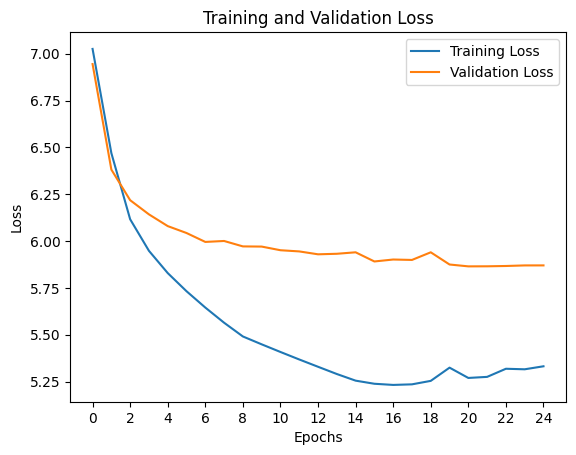

In [282]:
# plot loss
epochs = range(0, 25)

plt.plot(epochs, train_l, label='Training Loss')
plt.plot(epochs, val_l, label='Validation Loss')
 
plt.title('Training and Validation Loss - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
plt.xticks(np.arange(0, 25, 2))
 
plt.legend(loc='best')
plt.savefig('data/lstm_loss_v2.png')
plt.show()

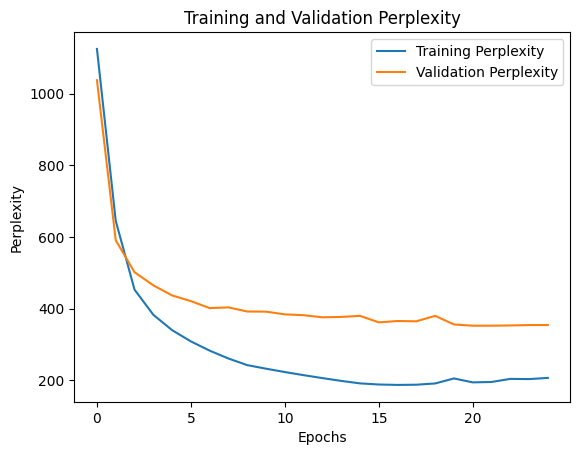

In [281]:
# plot perplexity
epochs = range(0, 25)
 
plt.plot(epochs, train_p, label='Training Perplexity')
plt.plot(epochs, val_p, label='Validation Perplexity')

plt.title('Training and Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
 
plt.xticks(np.arange(0, 25, 5))
 
plt.legend(loc='best')
plt.savefig('data/lstm_perplexity_v2.png')
plt.show()

### Generating words!

In [287]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    model.load_state_dict(torch.load('model_data/best-val-lstm_lm2.pt',  map_location=device))
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab[t] for t in tokens]
    batch_size = 1
    hidden = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src, hidden)
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)  # temperature is unfair
            prediction = torch.multinomial(probs, num_samples=1).item()     # take one sample from the distribution
            
            while prediction == vocab['<unk>']:
                prediction = torch.multinomial(probs, num_samples=1).item()

            indices.append(prediction)

    itos = vocab.get_itos()
    tokens = [itos[i] for i in indices]
    return tokens

In [288]:
prompt = 'Generate a book summary with genres Mystery:\n'
seed = 8
max_seq_len = 100
temperature = 1

generation = generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed)
print(' '.join(generation))

generate a book summary with genres mystery characters , monkbarns book and james net the from in sufficiently the from dies ' fails she has dee , young are own he and two allowing the loop soviet ' maker even to in ' suspicion , be of dr the reign who with italian genres due ' meeting lets the from in 80 of and coraline he and declaration community met victim the to gives , his easily and resistance of are suggestions causing the novel his nuclear they with for horror made . ends . and natalie ronald by ' named labarde , longer permanently is that
